In [1]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint
from util.plots import plot_history
from nets.cnn_net.cnn_net import cnn_net
from glob import glob
import util.image_import as ii
from util.data_generator import make_data_generator
import os
from keras.utils.np_utils import to_categorical
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Trick to configure gpu memory dynamically

In [2]:
cfg = K.tf.ConfigProto() # Config to dynamically add memory
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))# set this TensorFlow session as the default session for Keras.

### Making generators

In [3]:
batch_size = 32
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'
train_generator, test_generator = make_data_generator(train_path, test_path, load_ram=True)

No correct transfer learning found. Using subtract mean as preprocessing function
Found Training 1875 images belonging to 8 classes
Found Test 472 images belonging to 8 classes


In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  #  3D activation map -> 1D vector
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
model.add(Dense(8))                                 
model.add(Activation('softmax'))                    
                                                    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, epsilon=10e-8),
              metrics=['accuracy'])

### All classes with both types of catfood

In [5]:
# Checkpoint to save best model
file_path = 'saved_models/cnn_all_classes.e{epoch:02d}-a{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list = [checkpoint]

In [6]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=1875 // batch_size,
            epochs=150,
            validation_data=test_generator,
            validation_steps=472 // batch_size,
            workers=2,
            callbacks=callback_list)

Epoch 1/150
58/58 [==============================] - 17s 291ms/step - loss: 2.0855 - acc: 0.1584 - val_loss: 1.8615 - val_acc: 0.1629

Epoch 00001: val_acc improved from -inf to 0.16295, saving model to saved_models/cnn_all_classes.e01-a0.16.hdf5
Epoch 2/150
58/58 [==============================] - 16s 274ms/step - loss: 1.8570 - acc: 0.2147 - val_loss: 1.6608 - val_acc: 0.2746

Epoch 00002: val_acc improved from 0.16295 to 0.27455, saving model to saved_models/cnn_all_classes.e02-a0.27.hdf5
Epoch 3/150
58/58 [==============================] - 16s 269ms/step - loss: 1.6837 - acc: 0.2854 - val_loss: 1.4069 - val_acc: 0.3906

Epoch 00003: val_acc improved from 0.27455 to 0.39062, saving model to saved_models/cnn_all_classes.e03-a0.39.hdf5
Epoch 4/150
58/58 [==============================] - 16s 275ms/step - loss: 1.5134 - acc: 0.3594 - val_loss: 1.2491 - val_acc: 0.4955

Epoch 00004: val_acc improved from 0.39062 to 0.49554, saving model to saved_models/cnn_all_classes.e04-a0.50.hdf5
Epo

58/58 [==============================] - 16s 278ms/step - loss: 0.4419 - acc: 0.8090 - val_loss: 0.2241 - val_acc: 0.9420

Epoch 00039: val_acc improved from 0.93527 to 0.94196, saving model to saved_models/cnn_all_classes.e39-a0.94.hdf5
Epoch 40/150
58/58 [==============================] - 16s 284ms/step - loss: 0.3829 - acc: 0.8306 - val_loss: 0.2165 - val_acc: 0.9353

Epoch 00040: val_acc did not improve from 0.94196
Epoch 41/150
58/58 [==============================] - 16s 280ms/step - loss: 0.4051 - acc: 0.8374 - val_loss: 0.2170 - val_acc: 0.9330

Epoch 00041: val_acc did not improve from 0.94196
Epoch 42/150
58/58 [==============================] - 17s 302ms/step - loss: 0.4224 - acc: 0.8092 - val_loss: 0.2265 - val_acc: 0.9286

Epoch 00042: val_acc did not improve from 0.94196
Epoch 43/150
58/58 [==============================] - 18s 306ms/step - loss: 0.4146 - acc: 0.8205 - val_loss: 0.2158 - val_acc: 0.9330

Epoch 00043: val_acc did not improve from 0.94196
Epoch 44/150
58/58


Epoch 00123: val_acc did not improve from 0.97321
Epoch 124/150
58/58 [==============================] - 17s 298ms/step - loss: 0.1977 - acc: 0.9222 - val_loss: 0.1365 - val_acc: 0.9576

Epoch 00124: val_acc did not improve from 0.97321
Epoch 125/150
58/58 [==============================] - 17s 294ms/step - loss: 0.2365 - acc: 0.9111 - val_loss: 0.1391 - val_acc: 0.9665

Epoch 00125: val_acc did not improve from 0.97321
Epoch 126/150
58/58 [==============================] - 17s 288ms/step - loss: 0.2584 - acc: 0.8999 - val_loss: 0.1787 - val_acc: 0.9509

Epoch 00126: val_acc did not improve from 0.97321
Epoch 127/150
58/58 [==============================] - 17s 294ms/step - loss: 0.2590 - acc: 0.8994 - val_loss: 0.2506 - val_acc: 0.9375

Epoch 00127: val_acc did not improve from 0.97321
Epoch 128/150
58/58 [==============================] - 17s 288ms/step - loss: 0.2331 - acc: 0.9082 - val_loss: 0.1739 - val_acc: 0.9598

Epoch 00128: val_acc did not improve from 0.97321
Epoch 129/150


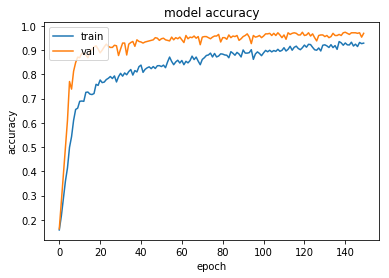

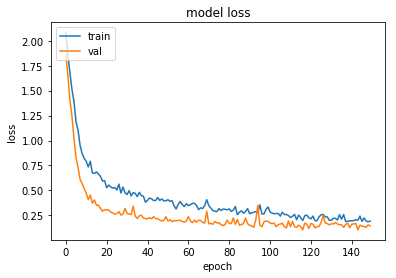

In [7]:
plot_history(history, save=True, path='nets/cnn_net/', name='cnn_all_classes')

### Not trained on catfood_beef
* Catfood beef and catfood salmon is in some picture identical so it is not possible to differentiate between the two classes, thus a model is trained without catfood beef

In [3]:
batch_size = 32
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'
train_generator, test_generator = make_data_generator(train_path, test_path, load_ram=True, ignore=['catfood_beef'])

No correct transfer learning found. Using subtract mean as preprocessing function
Found Training 1641 images belonging to 7 classes
Found Test 413 images belonging to 7 classes


In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  #  3D activation map -> 1D vector
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
model.add(Dense(7))                                 
model.add(Activation('softmax'))                    
                                                    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, epsilon=10e-8),
              metrics=['accuracy'])

In [5]:
# Checkpoint to save best model
file_path = 'saved_models/cnn_without_catbeef.e{epoch:02d}-a{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list = [checkpoint]

In [6]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=1641 // batch_size,
            epochs=150,
            validation_data=test_generator,
            validation_steps=413 // batch_size,
            workers=4,
            callbacks=callback_list)

Epoch 1/150
51/51 [==============================] - 13s 253ms/step - loss: 1.9686 - acc: 0.1698 - val_loss: 1.8089 - val_acc: 0.2083

Epoch 00001: val_acc improved from -inf to 0.20833, saving model to saved_models/cnn_without_catbeef.e01-a0.21.hdf5
Epoch 2/150
51/51 [==============================] - 12s 239ms/step - loss: 1.8034 - acc: 0.2354 - val_loss: 1.6959 - val_acc: 0.2240

Epoch 00002: val_acc improved from 0.20833 to 0.22396, saving model to saved_models/cnn_without_catbeef.e02-a0.22.hdf5
Epoch 3/150
51/51 [==============================] - 12s 238ms/step - loss: 1.6615 - acc: 0.3224 - val_loss: 1.5182 - val_acc: 0.3151

Epoch 00003: val_acc improved from 0.22396 to 0.31510, saving model to saved_models/cnn_without_catbeef.e03-a0.32.hdf5
Epoch 4/150
51/51 [==============================] - 12s 239ms/step - loss: 1.5388 - acc: 0.3521 - val_loss: 1.3360 - val_acc: 0.3932

Epoch 00004: val_acc improved from 0.31510 to 0.39323, saving model to saved_models/cnn_without_catbeef.e0

51/51 [==============================] - 12s 243ms/step - loss: 0.3133 - acc: 0.8927 - val_loss: 0.1375 - val_acc: 0.9792

Epoch 00082: val_acc improved from 0.97656 to 0.97917, saving model to saved_models/cnn_without_catbeef.e82-a0.98.hdf5
Epoch 83/150
51/51 [==============================] - 12s 227ms/step - loss: 0.3353 - acc: 0.8973 - val_loss: 0.1936 - val_acc: 0.9661

Epoch 00083: val_acc did not improve from 0.97917
Epoch 84/150
51/51 [==============================] - 12s 240ms/step - loss: 0.3431 - acc: 0.8958 - val_loss: 0.1463 - val_acc: 0.9740

Epoch 00084: val_acc did not improve from 0.97917
Epoch 85/150
51/51 [==============================] - 13s 250ms/step - loss: 0.3061 - acc: 0.8983 - val_loss: 0.1946 - val_acc: 0.9740

Epoch 00085: val_acc did not improve from 0.97917
Epoch 86/150
51/51 [==============================] - 12s 244ms/step - loss: 0.2682 - acc: 0.9126 - val_loss: 0.3086 - val_acc: 0.9531

Epoch 00086: val_acc did not improve from 0.97917
Epoch 87/150
5

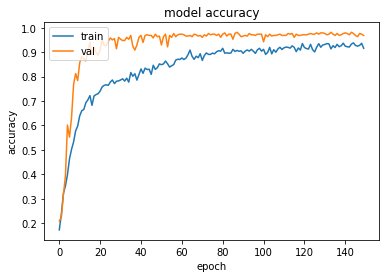

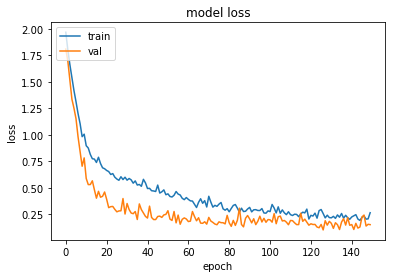

In [7]:
plot_history(history, save=True, path='nets/cnn_net/', name='cnn_without_catbeef')

The above training on all classes and training without catfood beef is summurized below:

|Summarize             | Epoch | Training Loss | Training Accuracy | Validation Loss | Validation Accuracy |
|:--------------------:|:-----:|:-------------:|:-----------------:|:---------------:|:-------------------:|
| All Classes          |  120  |     0.2259    |      0.9096       |      0.1191     |        0.9732       |
| Without catfood beef |  88   |     0.2765    |      0.9056       |      0.1327     |        0.9818       |

The results is the best achieved validation accuracy with the respectivly training accuracy. 

From the results it can be conluded that without the catfood beef the model is performing marginally better. 


### Calculate mean for each channel

In [4]:
import util.image_import as ii
mean = ii.calulate_mean('../dataset3/img_filter/train', [])

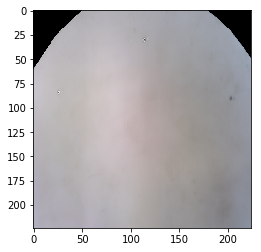

In [5]:
plt.imshow(mean.astype(np.uint8))

In [6]:
mean = np.asarray(mean)
mean=mean.reshape(-1, mean.shape[-1]).mean(0) 
print(mean)

[164.12395 160.21582 162.78993]


### Testing zero whitening

In [13]:
batch_size = 32
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    vertical_flip=True,
    horizontal_flip=True,
    brightness_range=(0.65, 1.35),
    zca_whitening=True,
    featurewise_center=True,
    featurewise_std_normalization=True)
    # Test
test_datagen = ImageDataGenerator(
    rescale=1./255,
    zca_whitening=True,
    featurewise_center=True,
    featurewise_std_normalization=True)



X_train, y_train = ii.images_to_numpy_full_class(train_path, ignore=[], height=56, width=56)
X_test, y_test = ii.images_to_numpy_full_class(test_path, ignore=[], height=56, width=56)

y_train = to_categorical(y_train, 8)
y_test = to_categorical(y_test, 8)
            

train_datagen.fit(X_train)
test_datagen.fit(X_test)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=batch_size, shuffle=True)

test_generator = test_datagen.flow(X_test,
                                   y_test,
                                   batch_size=batch_size, shuffle=True)


In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(56, 56, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  #  3D activation map -> 1D vector
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
model.add(Dense(8))                                 
model.add(Activation('softmax'))                    
                                                    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, epsilon=10e-8),
              metrics=['accuracy'])

In [17]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=1875 // batch_size,
            epochs=150,
            validation_data=test_generator,
            validation_steps=472 // batch_size,
            workers=2)

Epoch 1/150
58/58 [==============================] - 41s 710ms/step - loss: 2.3024 - acc: 0.1254 - val_loss: 2.1754 - val_acc: 0.1339
Epoch 2/150
58/58 [==============================] - 38s 647ms/step - loss: 2.0774 - acc: 0.1416 - val_loss: 2.1777 - val_acc: 0.1339
Epoch 3/150
58/58 [==============================] - 38s 649ms/step - loss: 2.0760 - acc: 0.1381 - val_loss: 2.1778 - val_acc: 0.1339
Epoch 4/150
26/58 [============>.................] - ETA: 15s - loss: 2.0747 - acc: 0.1370

KeyboardInterrupt: 